In [34]:
# import libraries
import numpy as np
import pandas as pd
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import re

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# load in directories
from experiment_code.constants import Defaults

In [57]:
# load in data from gorilla
df = pd.read_csv(os.path.join(Defaults.RAW_DIR, "gorilla_v3.csv"))

## Clean data

In [58]:
# filter dataframe to remove redundant cols
df_filtered = df.filter({'Experiment ID', 'Experiment Version', 'Task Version', 'Participant Private ID',
           'counterbalance-mpke', 'Spreadsheet Row', 'Zone Type', 
           'Reaction Time', 'Response', 'display', 'iti_dur_ms', 
           'trial_dur_ms', 'V1', 'V2', 'V2', 'V3', 'V4', 'V5',
          'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12'})

In [60]:
# clean spreadsheet
df_filtered = df_filtered.rename({'Zone Type':'Zone_Type', 'Spreadsheet Row': 'sentence_num','Participant Private ID':'Participant_Private_ID', 'counterbalance-mpke':'version'}, axis=1)
# df_filtered = df_filtered.rename({'Participant Private ID':'Participant_Private_ID'}, axis=1)

# select response-only rows and re-index
df_filtered = df_filtered.query('Zone_Type=="response_rating_scale_likert"')

# merge all versions into one column
df_filtered['sentence'] = df_filtered.apply(lambda row: row[row["version"]], axis=1)
df_filtered = df_filtered.drop({'V1', 'V2', 'V2', 'V3', 'V4', 'V5','V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12'}, axis=1)


## Investigate and remove outliers

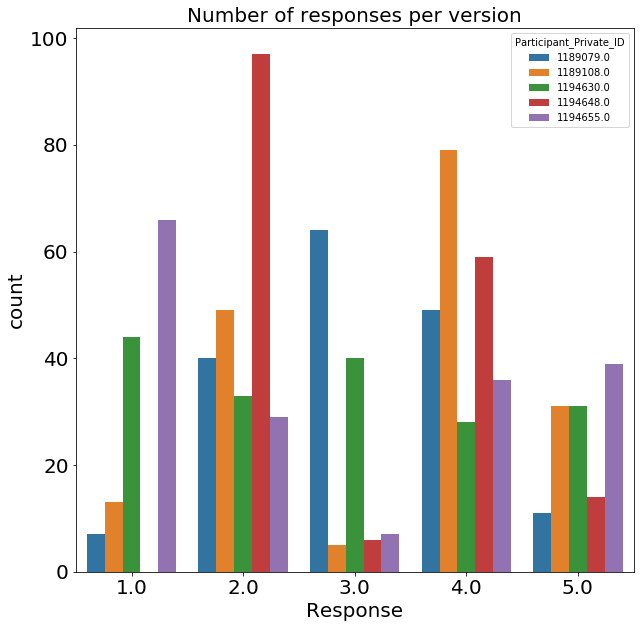

In [38]:
#Investigate Outliers 

def distribution_of_participants_per_version(version):
    "Gives distribution of scores for each participant of a particular version (where x='version', i.e. V1, V2, etc)"
    df_filtered_version = df_filtered.loc[df_filtered['version'] == version]
    df_filtered_version.Participant_Private_ID.unique()
    
    plt.figure(figsize=(10,10));
    sns.countplot(x='Response', hue='Participant_Private_ID', data= df_filtered_version);
    plt.xlabel('Response', fontsize=20)
    plt.ylabel('count', fontsize=20)
    plt.title('Number of responses per version', fontsize=20);
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20);


distribution_of_participants_per_version("V2");

In [5]:
# remove bad subjs
def remove_bad_subjs(dataframe, participant_private_id):

    dataframe = dataframe.query('Participant_Private_ID!=1194659.0')
    
    return dataframe
    
df_filtered = remove_bad_subjs(df_filtered, participant_private_id=1194659.0)

## Visualizations

## Distribution of versions

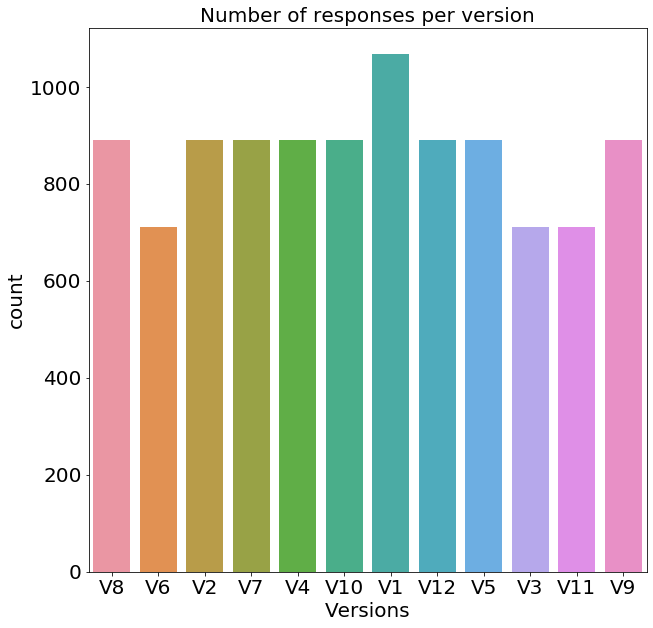

In [148]:
plt.figure(figsize=(10,10))

sns.countplot(x='version', data=df_filtered)
# sns.barplot(x='version', y='Response', data=df_filtered)
plt.xlabel('Versions', fontsize=20)
plt.ylabel('count', fontsize=20)
plt.title('Number of responses per version', fontsize=20);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

## Distribution of CoRT scores

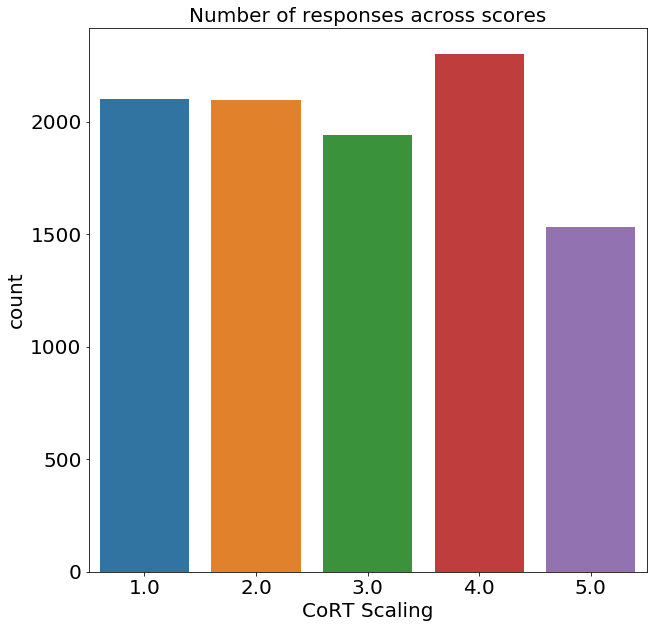

In [147]:
plt.figure(figsize=(10,10))

sns.countplot(x='Response', data=df_filtered)
plt.xlabel('CoRT Scaling', fontsize=20)
plt.ylabel('count', fontsize=20)
plt.title('Number of responses across scores', fontsize=20);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

## Distrubution of CoRT scores broken down by version

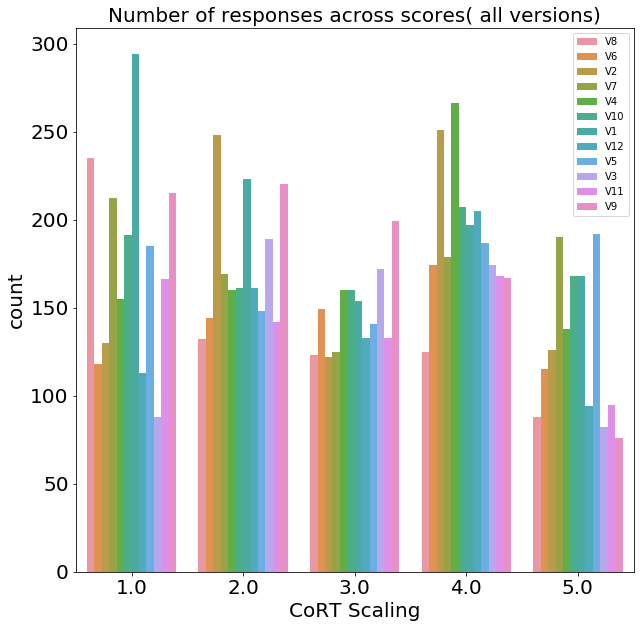

In [209]:
plt.figure(figsize=(10,10))
ax = sns.countplot(x='Response', hue='version', data=df_filtered)
ax.legend(loc='best', bbox_to_anchor=(1,1))
plt.xlabel('CoRT Scaling', fontsize=20)
plt.ylabel('count', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Number of responses across scores( all versions)', fontsize=20);

## Calculate SDs for each item

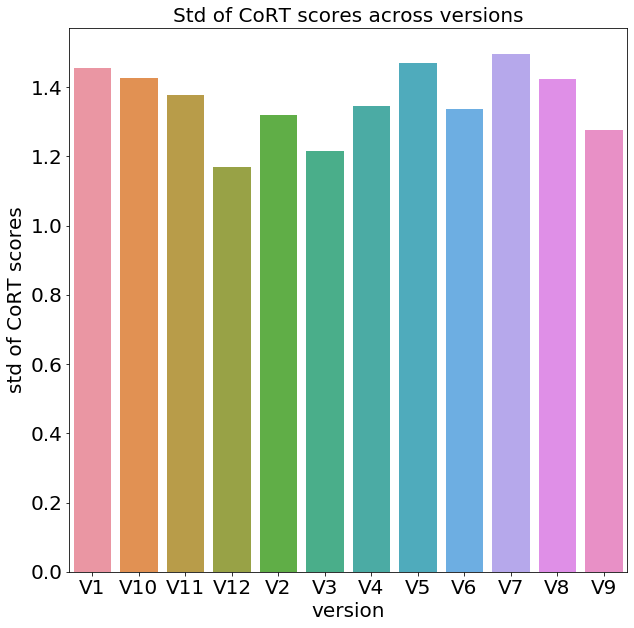

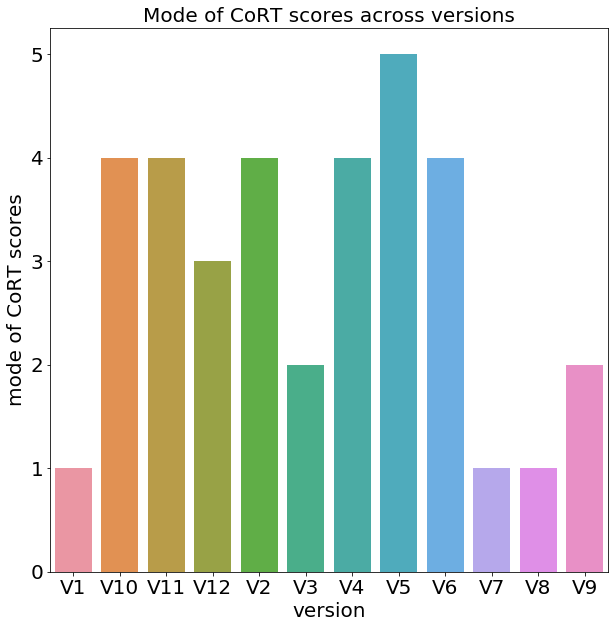

In [145]:
# plot mode and std of versions
plt.figure(figsize=(10,10))

x = df_filtered.groupby('version').apply(lambda x: x[['Response']].std()).reset_index()
sns.barplot(x=x['version'], y=x['Response']);
plt.xlabel('version', fontsize=20)
plt.ylabel('std of CoRT scores', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Std of CoRT scores across versions', fontsize=20);


plt.figure(figsize=(10,10))

x = df_filtered.groupby('version').apply(lambda x: x[['Response']].mode()).reset_index()
sns.barplot(x=x['version'], y=x['Response']);
plt.xlabel('version', fontsize=20)
plt.ylabel('mode of CoRT scores', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Mode of CoRT scores across versions', fontsize=20);

## Incorporate cloze probabilities

In [199]:
# load cloze probabilities dataframe
# clean the data to create new "clean" sentence column
# merge cloze dataframe with cort scaling dataframe

df_cloze = pd.read_csv(os.path.join(Defaults.STIM_DIR, "Peele_cloze_3.csv"))
df_cloze['sentence_new'] = df_cloze['sentence'].str.extract(pat = "([A-Za-z ,']+)") 
df_cloze['full_sentence'] = df_cloze['sentence_new'] + '' + df_cloze['target word']
df_cloze = df_cloze.drop({'sentence', 'sentence_new', 'target word'}, axis=1)

# merge cloze dataframe with cort results
df_cloze_cort = df_filtered.merge(df_cloze, left_on='sentence', right_on='full_sentence')
df_cloze_cort = df_cloze_cort.dropna()

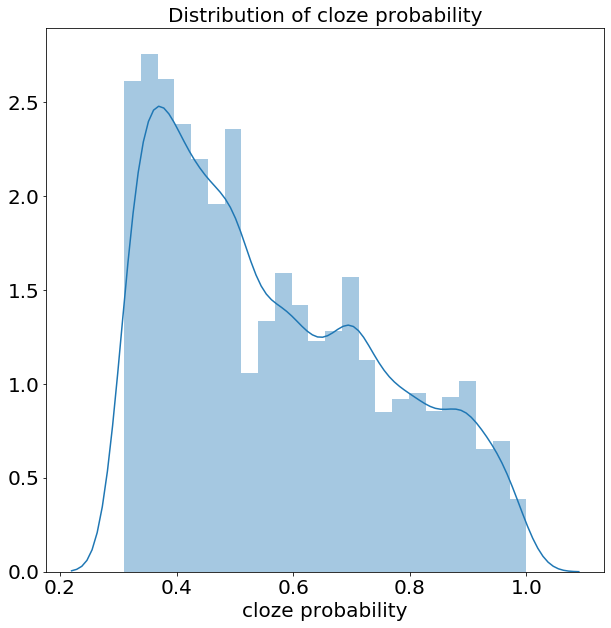

In [200]:
# Visualize distribution of cloze probability

plt.figure(figsize=(10,10))

sns.distplot(df_cloze_cort['cloze probability'])
plt.xlabel('cloze probability', fontsize=20)
plt.title('Distribution of cloze probability', fontsize=20);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

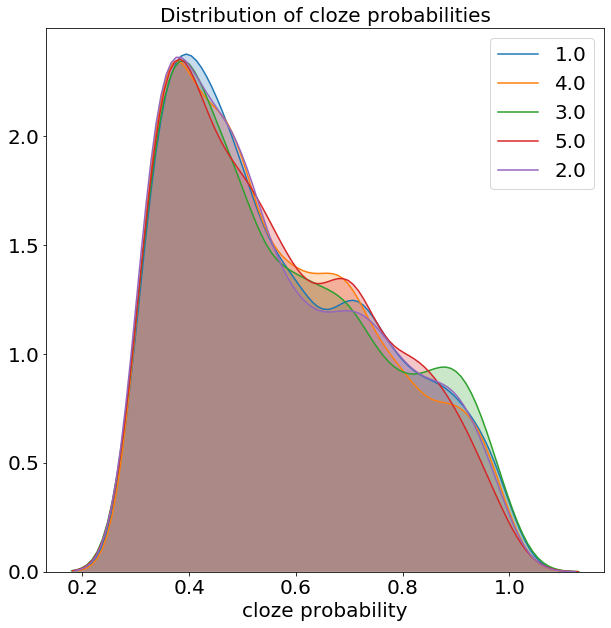

In [203]:
# Visualize distribution of cloze probabilities across cort scores

cort_scores = df_cloze_cort['Response'].unique()

plt.figure(figsize=(10,10))

# plot histogram of cloze probabilities for each cort scale
for cort in cort_scores:
#     plt.figure()
    sns.kdeplot(df_cloze_cort.loc[df_cloze_cort['Response']==cort]['cloze probability'], shade=True)
    plt.title(f'Distribution of cloze probabilities', fontsize=20)
    plt.xlabel('cloze probability', fontsize=20)
    plt.legend(cort_scores, fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

## Select for final sentences